In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 


In [74]:
archivo = "Data/Homework3pt1DataCSV.txt"
# Lee la matriz desde el archivo
rates = np.loadtxt(archivo)

In [75]:
categories=["A0º", "A30º", "V0º", "V30º", "A0º V0º", "A0º V30º", "A30º V0º", "A30º V30º"]
audio=[0, 30, np.nan, np.nan, 0, 0, 30, 30]
visual=[np.nan, np.nan, 0, 30, 0, 30, 0, 30]
subplot_id=[4, 7, 2, 3, 5, 6, 8, 9]
n_bins=15


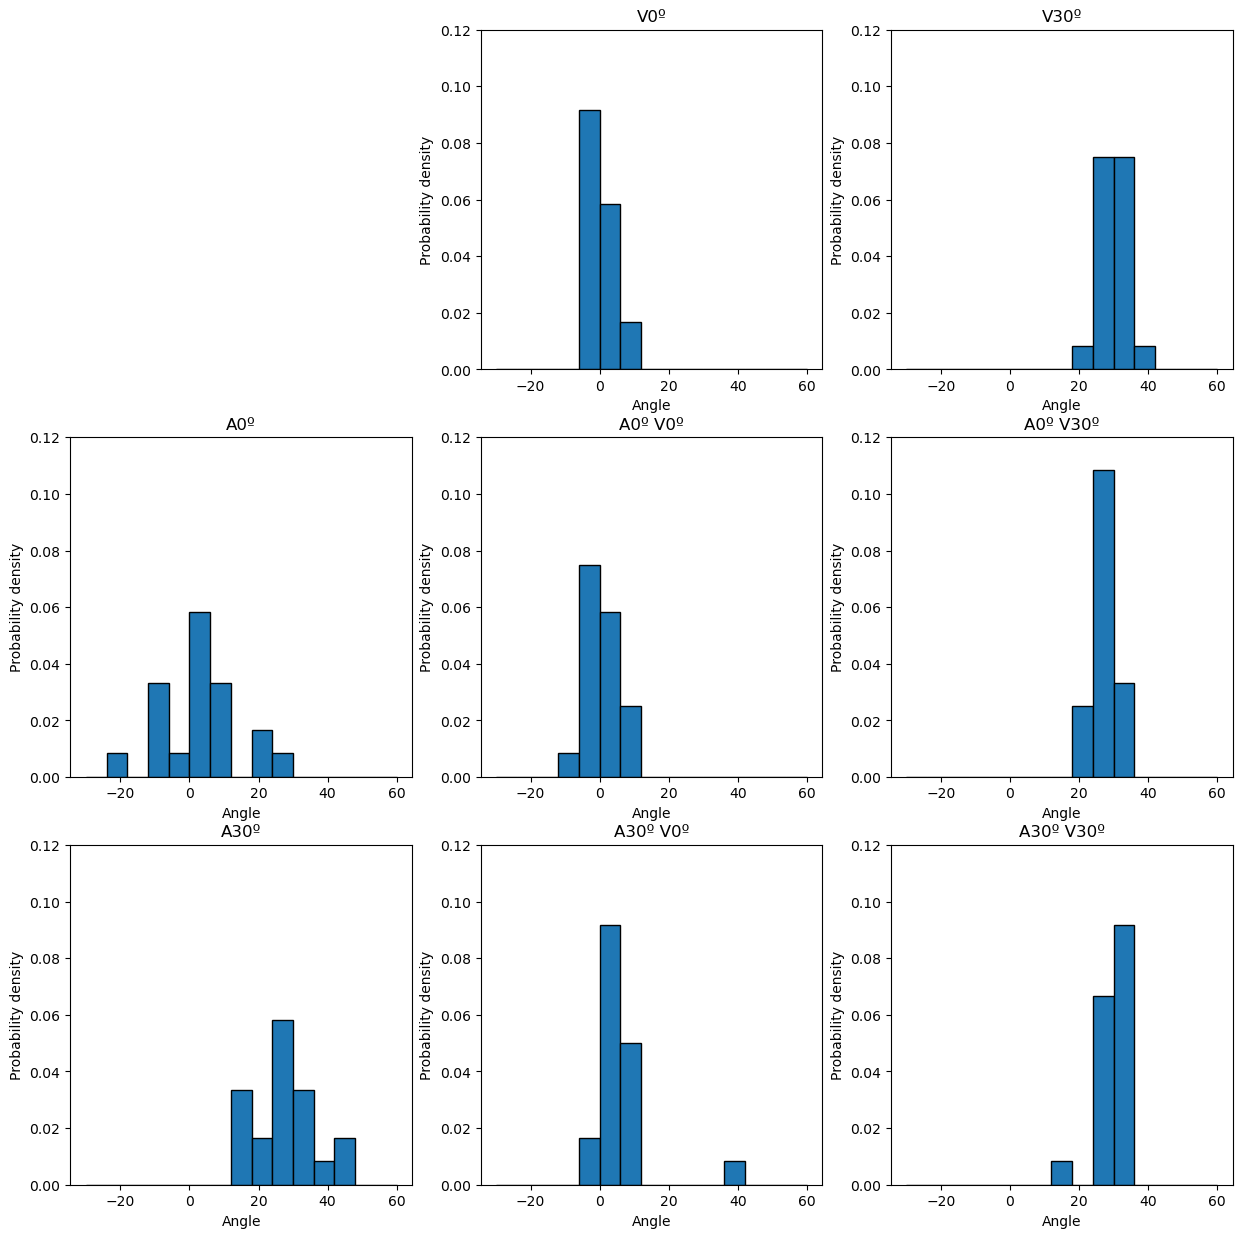

In [76]:
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(3,3, subplot_id[i])
    n, bins, patches = plt.hist(rates[i], bins=n_bins, edgecolor="black", density=True, range=(-30,60)) #
    n/=20
    plt.title(categories[i])
    plt.ylim(top=0.12)
    plt.xlabel("Angle")
    plt.ylabel("Probability density")


In [77]:
mean=[]
std=[]
for i in range(8):
    mean.append(np.mean(rates[i]))
    std.append(np.std(rates[i]))

    

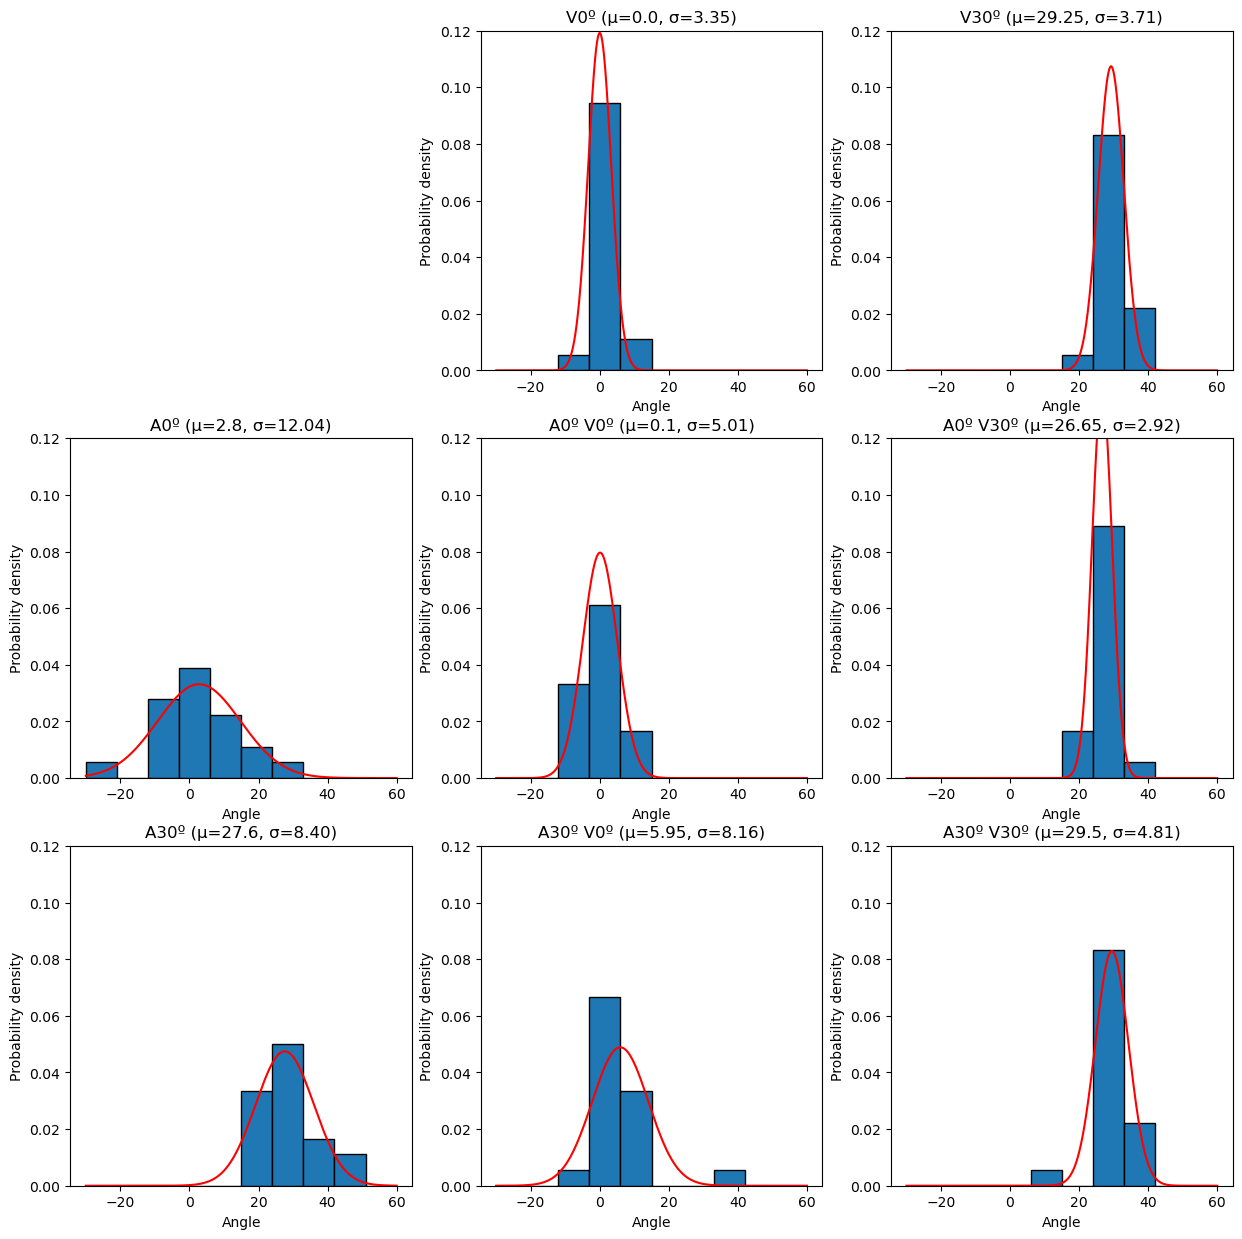

In [78]:
n_bins=10
x_points=np.zeros((8, n_bins))
y_points=np.zeros((8, n_bins))
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(3,3, subplot_id[i])
    n, bins, patches=plt.hist(rates[i], bins=n_bins, edgecolor="black", density=True, range=(-30,60))
    y_points[i]=n
    x_points[i]=0.5 * (bins[1:] + bins[:-1])
    #x = np.linspace(min(rates[i]), max(rates[i]), 100)
    x = np.linspace(-30, 60, 1000)
    y=norm.pdf(x, mean[i], std[i])
    plt.plot(x, y, 'r', label='Distribución Gaussiana')
    #plt.plot(x_points[i], y_points[i], 'o', color='red', label='original')
    plt.ylim(top=0.12)
    plt.title(f"{categories[i]} (μ={mean[i]}, σ={std[i]:.2f})")
    plt.xlabel("Angle")
    plt.ylabel("Probability density")

In [79]:
from scipy.optimize import minimize, LinearConstraint

Weight formula

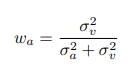

Mu_audiovisual

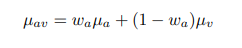

Sigma_audiovisual

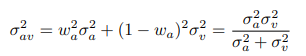

In [80]:
def weight(sigma_a, sigma_v):
    wa= sigma_v**2/(sigma_a**2 + sigma_v**2)
    return wa
def mu_av_trans(mu_a, mu_v, sigma_a, sigma_v):
    wa=weight(sigma_a, sigma_v)
    t=wa*mu_a +(1-wa)*mu_v
    return t

def sigma_av_trans(sigma_a, sigma_v):
    wa=weight(sigma_a, sigma_v)
    t=wa**2*sigma_a**2 + (1-wa)**2*sigma_v**2
    t=np.sqrt(t)
    return t


In [81]:
def negative_log_likelihood(params, x):
    #params=mu_a0, mu_a30,  mu_v0, mu_v30, sigma_a, sigma_v
    mus_indices = [0, 1, 2, 3]
    sigmas_indices = [4, 5]
    mus = params[mus_indices]
    sigmas = params[sigmas_indices]
    nll=0
    a_av=[0,0,1,1]      #This  is for combining in the same order as the stimulus are saved in the x. Audio 0, Audio 0, Audio 30, Audio 30
    v_av=[2,3,2,3]      #Visual 0, Visual 30, Visual 0, Visual 30
    #unisensorial.
    for i in range(4):
        mu=mus[i]
        sigma=sigmas[0] if i in [0,1] else sigmas[1] #cogemos la sigma audio, si no audiovisual
        nll += np.sum(0.5 * np.log(2 * np.pi * sigma**2) + 0.5 * ((x[int(i)] - mu) / sigma)**2)
    #audiovisual
    for i in [0,1,2,3]:
        mu_a=params[a_av[i]]
        sigma_a=sigmas[0]
        mu_v=params[v_av[i]]
        sigma_v=sigmas[1]
        mu_av=mu_av_trans(mu_a, mu_v, sigma_a, sigma_v)
        sigma_av=sigma_av_trans(sigma_a, sigma_v)
        nll += np.sum(0.5 * np.log(2 * np.pi * sigma_av**2) + 0.5 * ((x[i+4] - mu_av) / sigma_av)**2)
    return nll

In [82]:
initial_guess=[0, 30, 0,30,1,1]
bnds = ((-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (0.0001, np.inf),(0.0001, np.inf))
optimized_parameters = minimize(negative_log_likelihood, initial_guess, args=rates, bounds=bnds)
params = ['mu_a0', 'mu_a30', 'mu_v0', 'mu_v30', 'sigma_a', 'sigma_v']
print("{:<15} {:<15}".format("Parameters", "Values"))
print("-" * 30)

for dato1, dato2 in zip(params, optimized_parameters.x):
    print("{:<15} {:<15.3f}".format(dato1, dato2))

Parameters      Values         
------------------------------
mu_a0           3.335          
mu_a30          28.163         
mu_v0           0.207          
mu_v30          30.143         
sigma_a         11.508         
sigma_v         5.294          


In [83]:
NLL=negative_log_likelihood(optimized_parameters.x, rates)
print(f"The NLL of the fit is {NLL :.3f}")

The NLL of the fit is 517.061


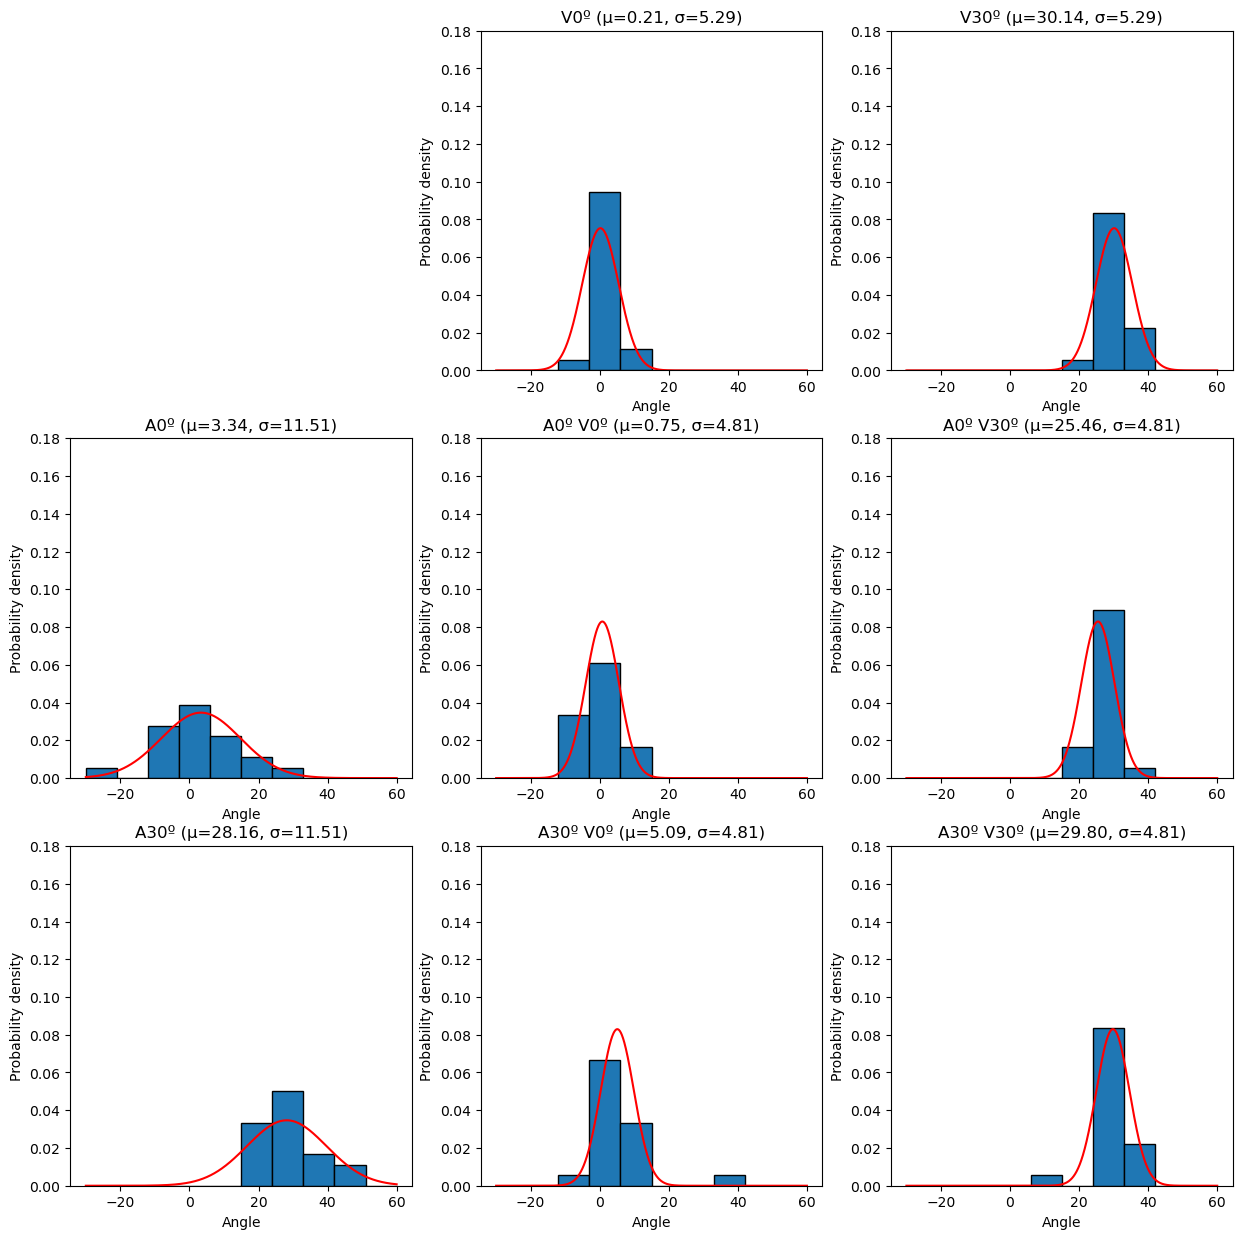

In [84]:
#Plot the models' probability density and the corresponding histogram for each
#stimulus type. Evaluate the model fits by visual inspection
mu_a0 = optimized_parameters.x[0]
mu_a30 = optimized_parameters.x[1]
mu_v0 = optimized_parameters.x[2]
mu_v30 = optimized_parameters.x[3]
sigma_a = optimized_parameters.x[4]
sigma_v = optimized_parameters.x[5]

mu_a0v0 = mu_av_trans(mu_a0, mu_v0, sigma_a, sigma_v)
sigma_a0v0=sigma_av_trans(sigma_a, sigma_v)
mu_a0v30=mu_av_trans(mu_a0, mu_v30, sigma_a, sigma_v)
sigma_a0v30=sigma_av_trans(sigma_a, sigma_v)
mu_a30v0=mu_av_trans(mu_a30, mu_v0, sigma_a, sigma_v)
sigma_a30v0=sigma_av_trans(sigma_a, sigma_v)
mu_a30v30=mu_av_trans(mu_a30, mu_v30, sigma_a, sigma_v)
sigma_a30v30=sigma_av_trans(sigma_a, sigma_v)

n_bins=10
x_points=np.zeros((8, n_bins))
y_points=np.zeros((8, n_bins))
plt.figure(figsize=(15,15))
mean = [mu_a0, mu_a30, mu_v0, mu_v30, mu_a0v0, mu_a0v30, mu_a30v0, mu_a30v30]
std = [sigma_a, sigma_a, sigma_v, sigma_v, sigma_a0v0, sigma_a0v30, sigma_a30v0, sigma_a30v30]

for i in range(8):
    plt.subplot(3,3, subplot_id[i])
    n, bins, patches=plt.hist(rates[i], bins=n_bins, edgecolor="black", density=True, range=(-30,60))
    y_points[i]=n
    x_points[i]=0.5 * (bins[1:] + bins[:-1])
    #x = np.linspace(min(rates[i]), max(rates[i]), 100)
    x = np.linspace(-30, 60, 1000)
    y = norm.pdf(x, mean[i], std[i])
    plt.plot(x, y, 'r', label='Distribución Gaussiana')
    #plt.plot(x_points[i], y_points[i], 'o', color='red', label='original')
    plt.ylim(top=0.18)
    plt.title(f"{categories[i]} (μ={mean[i]:.2f}, σ={std[i]:.2f})")
    plt.xlabel("Angle")
    plt.ylabel("Probability density")

# Cross - validation

In [85]:
def negative_log_likelihood_test(params, x, pos):
    #params=mu_a0, mu_a30,  mu_v0, mu_v30, sigma_a, sigma_v
    mus_indices = [0, 1, 2, 3]
    sigmas_indices = [4, 5]
    mus = params[mus_indices]
    sigmas = params[sigmas_indices]
    nll=0
    a_av=[0,0,1,1]      #This  is for combining in the same order as the stimulus are saved in the x. Audio 0, Audio 0, Audio 30, Audio 30
    v_av=[2,3,2,3]      #Visual 0, Visual 30, Visual 0, Visual 30
    if pos in [0,1,2,3]:
        mu=mus[pos]
        sigma=sigmas[0] if pos in [0,1] else sigmas[1] #cogemos la sigma audio, si no audiovisual
        nll = np.sum(0.5 * np.log(2 * np.pi * sigma**2) + 0.5 * ((x - mu) / sigma)**2)
        return nll
    if pos in [4,5,6,7]:
        i=pos-4
        mu_a=params[a_av[i]]
        sigma_a=sigmas[0]
        mu_v=params[v_av[i]]
        sigma_v=sigmas[1]
        mu_av=mu_av_trans(mu_a, mu_v, sigma_a, sigma_v)
        sigma_av=sigma_av_trans(sigma_a, sigma_v)
        nll = np.sum(0.5 * np.log(2 * np.pi * sigma_av**2) + 0.5 * ((x - mu_av) / sigma_av)**2)
        return nll
    
def negative_log_likelihood_train(params, x):
    #params=mu_a0, sigma_a0, mu_a30, sigma_a30, mu_v0, sigma_v0, mu_v30, sigma_v30
    mus_indices = [0, 1, 2, 3]
    sigmas_indices = [4, 5]
    mus = params[mus_indices]
    sigmas = params[sigmas_indices]
    nll=0
    a_av=[0,0,1,1]      #This  is for combining in the same order as the stimulus are saved in the x. Audio 0, Audio 0, Audio 30, Audio 30
    v_av=[2,3,2,3]      #Visual 0, Visual 30, Visual 0, Visual 30
    #unisensorial.
    for i in [0,2,4,6]:
        if not np.isnan(x[int(i/2)][0]):
            j=int(i/2)
            mu=mus[j]
            sigma=sigmas[0] if j in [0,1] else sigmas[1] #cogemos la sigma audio, si no audiovisual
            nll += np.sum(0.5 * np.log(2 * np.pi * sigma**2) + 0.5 * ((x[int(j)] - mu) / sigma)**2)
    #audiovisual
    for i in [0,1,2,3]:
        if not np.isnan(x[int(i+4)][0]):
            mu_a=params[a_av[i]]
            sigma_a=sigmas[0]
            mu_v=params[v_av[i]]
            sigma_v=sigmas[1]
            mu_av=mu_av_trans(mu_a, mu_v, sigma_a, sigma_v)
            sigma_av=sigma_av_trans(sigma_a, sigma_v)
            nll += np.sum(0.5 * np.log(2 * np.pi * sigma_av**2) + 0.5 * ((x[i+4] - mu_av) / sigma_av)**2)
    return nll

Iteration 0
[ 6.91828123 28.16041542 -0.25644965 30.06691159 10.93606327  5.32393392]
Iteration 1
[ 3.12091525 36.60821949  0.25587552 29.31529294 13.30205533  5.24817401]
Iteration 2
[ 3.52550965 27.90712987  0.10593403 30.28253482 11.68194396  5.6025133 ]
Iteration 3
[3.21145804e+00 2.71948598e+01 6.61676347e-03 3.12609919e+01
 1.13062209e+01 5.62487470e+00]
Iteration 4
[ 3.85278384 28.0083466   0.63524958 30.07901451 11.50758377  5.22546616]
1.1852801404211903
4.7579071764856105
Iteration 5
[ 2.4795538  28.07545205 -0.12023001 29.5259965  11.1077394   5.6953372 ]
23.895724873966845
5.067984519700129
Iteration 6
[ 2.97074726 27.69083344 -0.14374674 29.65451281 11.02045929  4.15357615]
3.3183887418592706
3.8866853762278306
Iteration 7
[ 3.25740427 28.40480759  0.18229858 30.33041309 11.47211733  5.29900052]
29.991818071798534
4.81061056989993


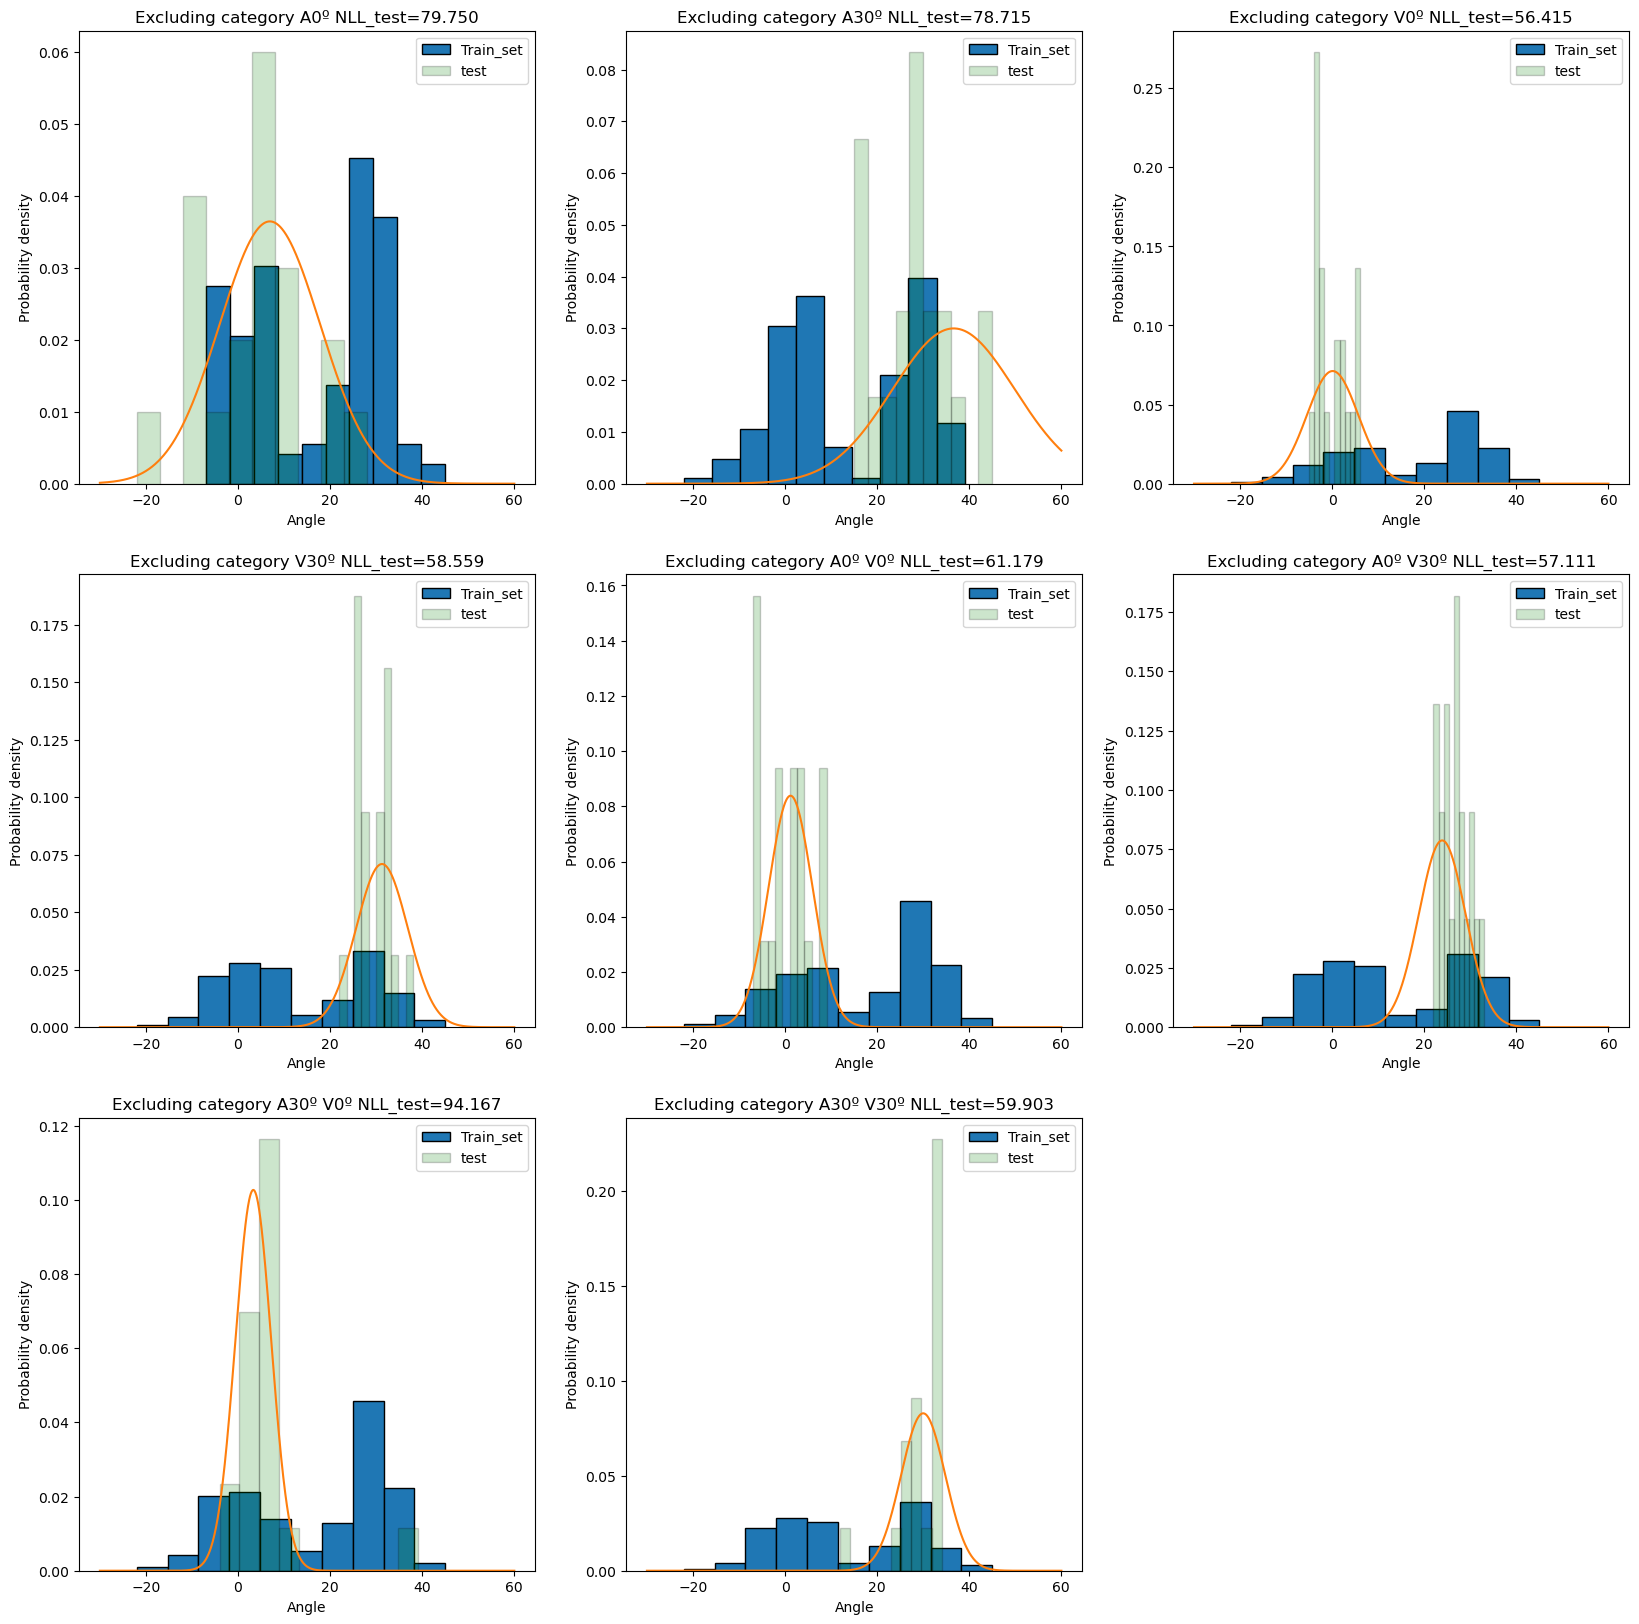

In [86]:
NLL_test_array=[]
NLL_train_array=[]
plt.figure(figsize=(20, 20))
for i in range(len(rates)):
    train=rates.copy()
    aux=rates.copy()
    test=aux[i]
    train[i]=np.full(len(train[0]), np.nan)
    initial_guess=[0, 30, 0,30,1,1]
    bnds = ((-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (0.0001, np.inf),(0.0001, np.inf))
    optimized_parameters = minimize(negative_log_likelihood_train, initial_guess, args=(train), bounds=bnds)   #We optimize using minimize function from scipy library
    all_params=optimized_parameters.x
    print("Iteration " + str(i))
    print(all_params)
    NLL_test=negative_log_likelihood_test(optimized_parameters.x, test, i)
    NLL_train=negative_log_likelihood_train(optimized_parameters.x, train)

    NLL_test_array.append(NLL_test)
    NLL_train_array.append(NLL_train)
    mascara = np.ones(train.shape[0], dtype=bool)
    mascara[i] = False
    # Seleccionar las filas utilizando la máscara
    train = train[mascara, :]
    plt.subplot(3,3,i+1)
    plt.hist(train.flatten(), bins=10, edgecolor="black", density=True,  label="Train_set")
    plt.hist(test, bins=10, color="green", alpha=0.2,  edgecolor="black", density=True, label="test")
    #params=mu_a0, mu_a30,  mu_v0, mu_v30, sigma_a, sigma_v
    if i in [0,1,2,3]:
        if i in[0,1]:
            plt.plot(x, norm.pdf(x, optimized_parameters.x[i], optimized_parameters.x[4]))
        else:
            plt.plot(x, norm.pdf(x, optimized_parameters.x[i], optimized_parameters.x[5]))
    else: 
        pos=i-4
        a_av=[0,0,1,1]      #This  is for combining in the same order as the stimulus are saved in the x. Audio 0, Audio 0, Audio 30, Audio 30
        v_av=[2,3,2,3]      #Visual 0, Visual 30, Visual 0, Visual 30
        mu_a=optimized_parameters.x[a_av[pos]]
        sigma_a=optimized_parameters.x[4]
        mu_v=optimized_parameters.x[v_av[pos]]
        sigma_v=optimized_parameters.x[5]
        mu_av=mu_av_trans(mu_a, mu_v, sigma_a, sigma_v)
        sigma_av=sigma_av_trans(sigma_a, sigma_v)
        print(mu_av)
        print(sigma_av)
        plt.plot(x, norm.pdf(x, mu_av,sigma_av))
    plt.title(f"Excluding category {categories[i]} NLL_test={NLL_test:.3f}")
    plt.ylim()
    plt.xlabel("Angle")
    plt.ylabel("Probability density")
    plt.legend()




In [89]:
print(np.sum(NLL_test_array))

545.7995601242711
